# Matrix Factorization 2 

**Cold Start Problem** 과 **주기적 재학습** 문제에 해결하기 위해 등장한 방법들을 확인해 봅니다.


In [1]:
import os
import pickle
import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from tensorboard.plugins import projector

import seaborn as sns
import matplotlib.pyplot as plt

import gdown
from IPython.display import clear_output
%load_ext tensorboard

2025-03-20 09:29:49.056915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742462989.068445   82674 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742462989.071974   82674 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# GPU의 메모리를 충분히 확보할 수 있도록 세팅을  합니다.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1742462991.065631   82674 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4784 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


## MovieLens25M 데이터 준비

대규모 데이터셋을 사용합니다.

In [3]:
# 영화 메타데이터를 가져옵니다. (한국어 버젼)
with open('dataset/tmdb_movie_info_kr.pkl', 'rb') as f:
    dic_movie_info_kr = pickle.load(f)

# OpenAI의 Embedding API를 통해 구한 영화 타이틀과 줄거리의 Embedding 데이터를 불러 옵니다. (영어 버젼)
with open('dataset/tmdb_movie_emb.pkl', 'rb') as f:
    movie_info_emb = pickle.load(f)

In [4]:
# 평점을 불러옵니다.
dtype = {'rating': 'float16'}
df_ratings = pd.read_csv('dataset/ratings.csv', dtype=dtype)
# 일자를 timestamp 형식(Integer)에서 일자형식으로 바꿉니다.
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
# 평점수, 영화수, 사용자수
len(df_ratings), df_ratings['movieId'].nunique(), df_ratings['userId'].nunique()

(25000095, 59047, 162541)

In [5]:
# 영화의 간략 버젼의 메타데이터를 불러옵니다.
df_movie = pd.read_csv('dataset/movies.csv', index_col='movieId')

# 영화 출시일을 영화 메타데이터에서 가져옵니다.
df_movie['release_date'] = df_movie.index.map(
    lambda x: dic_movie_info_kr.get(x, {'release_date': None}).get('release_date', None)
).values

# 결측일 경우 평점 데이터에서 가장 먼저 출현한 시점으로 잡습니다.
s_date_fillna = df_ratings.loc[
    df_ratings['movieId'].isin(df_movie.loc[df_movie['release_date'].isna()].index)
].groupby('movieId')['date'].min()
df_movie.loc[df_movie.index.isin(s_date_fillna.index), 'release_date'] = pd.to_datetime(s_date_fillna)
df_movie['release_date'] = pd.to_datetime(df_movie['release_date'] )

# 영화 출시 시점과 평가 시점과 차(일자 단위)
df_ratings['days'] = (df_ratings['date'] - df_ratings['movieId'].map(df_movie['release_date'])).dt.days.clip(0)

In [6]:
# 영화 당 여러 개의 genre(장르)가 부여됩니다(movie:genre=1:N 관계). 이를 위한 처리를 합니다. (movieId, genre 리스트)인 튜플로 된 리스트를 만듭니다.
l_genre = [(k, [i['name'] for i in v['genres']]) for k, v in dic_movie_info_kr.items()]
# movieId, genres 리스트 컬럼으로된 DataFrame을 만듭니다
df_genre = pd.DataFrame(l_genre, columns=['movieId', 'genres']).set_index('movieId')
# movieId, genre로 된 DataFrame을 만듭니다.
df_genre = df_genre['genres'].explode().dropna()
# genre를 1 기준(1-base)의 인덱스로 변환하기 위한 매핑을 만듭니다.
s_genre_map = pd.Series(np.arange(1, df_genre.nunique() + 1), index=df_genre.unique())
# 처리 효율성을 위해 영화의 genre 정보를 genre에 대한 1-기준(1-base) 인덱스으로 변환합니다.
s_genre = df_genre.map(s_genre_map).pipe(lambda x: x.groupby(level=0).agg(list))
del l_genre, df_genre
s_genre.head()

movieId
1    [1, 2, 3, 4]
2       [2, 5, 3]
3          [6, 4]
4       [4, 7, 6]
5          [4, 3]
Name: genres, dtype: object

In [7]:
# 영화의 시리즈 정보를 정리합니다.(movie:series=1:1 관계)
l_series = [
    (k,  v['belongs_to_collection']['name']) 
    for k, v in dic_movie_info_kr.items() if v['belongs_to_collection'] is not None
]
# 영화에 부여된 시리즈  정보를 pd.Series 형태로 만듭니다.
s_series = pd.DataFrame(l_series, columns=['movieId', 'collection']).set_index('movieId')['collection']
# 영화의 시리즈 정보를 1-base 인덱스로 변환하기 위한 매핑을 합니다.
s_collection = pd.Series(np.arange(1, s_series.nunique() + 1), index = s_series.unique())
# 영화의 시리즈 정보를 1-base 인덱스로 변환합니다. 
s_series = s_series.map(s_collection)
del l_series

In [8]:
# 사용자가 이전 시점에 평가한 이력을 만들기 위해 userId와 date로 정렬합니다.
df_ratings.sort_values(['userId', 'date'], inplace=True)

In [9]:
# 바로 이전에 시청한 내역을 구하여 prev_movieId, prev_rating에 넣습니다.
df_ratings[['prev_movieId', 'prev_rating']] = df_ratings[['movieId', 'rating']].shift(1)
df_ratings['prev_movieId'] = df_ratings['prev_movieId'].fillna(0).astype('int')
# 현 시점의 사용자와 이전에 시청한 이력의 사용자가 다를 경우에는 이전 시청 이력이 없는 것입니다.
# 시청이력이 없음을 prev_movieId와 prev_rating를 0으로 나타냅니다.
df_ratings.loc[df_ratings['userId'] != df_ratings['userId'].shift(1), ['prev_movieId', 'prev_rating']] = [0, np.nan]

In [10]:
# 2019-01-01 이전은 학습셋, 2019-01-01 이후는 평가셋으로 나눕니다.
# sample(frac=1) 시점에 대해 정렬된 데이터를 섞어 Batch Gradient Descent시 시점에 대한 치우침 문제가 발생하지 않도록 합니다.
df_train = df_ratings.loc[df_ratings['date'] < '2019-01-01'].sample(frac=1).copy()
df_test = df_ratings.loc[df_ratings['date'] >= '2019-01-01'].copy()
# 학습과 평가 데이터에 비율을 구합니다.
len(df_train) / len(df_ratings), len(df_test) / len(df_ratings)

(0.9519748224956746, 0.048025177504325486)

In [11]:
rating_train_mean = df_train['rating'].astype('float64').mean()
# 이전 평점이 없는 경우 학습 데이터에서의 평균 평점으로 대체합니다.
df_train['prev_rating'] = df_train['prev_rating'].fillna(rating_train_mean)
# 이전 평점이 없는 경우 학습 데이터에서의 평균 평점으로 대체합니다.
df_test['prev_rating'] = df_test['prev_rating'].fillna(rating_train_mean)
df_test.sort_index()

,userId,movieId,rating,date,days,prev_movieId,prev_rating
299,3,1274,4.5,2019-08-18 00:40:19,11355.0,168252,4.0
307,3,1732,4.5,2019-08-18 01:31:23,7835.0,4262,4.5
311,3,1960,4.0,2019-08-18 01:12:46,11641.0,57528,3.0
313,3,2021,4.0,2019-08-18 00:50:49,12665.0,52950,4.5
329,3,3408,3.5,2019-08-18 00:56:13,7093.0,3977,2.5
...,...,...,...,...,...,...,...
24999518,162536,148626,5.0,2019-10-28 10:42:27,1417.0,55765,4.0
24999519,162536,148685,5.0,2019-10-28 10:16:53,1424.0,204698,4.5
24999520,162536,164179,4.0,2019-10-28 10:37:58,1082.0,106920,5.0
24999521,162536,202429,4.0,2019-10-28 10:16:22,96.0,122914,2.0


In [12]:
# 사용자별 평가수를 구합니다.
s_userCnt = df_train['userId'].value_counts()
# 영화별 평가수를 구합니다.
s_movieCnt = df_train['movieId'].value_counts()

In [13]:
# pd.DataFrame을 tf.Dataset으로 바꾸어 줍니다.
# (Dictionary, List) 형태의 튜플로 구성됩니다.
# 입력변수는 userId, movieId, prev_movieId, prev_rating
# 입력 변수는 Model에 전달될 때, 키 값이 userId, movieId, prev_movieId, prev_rating인 Dictionary 형태로 전달이됩니다.
# 대상변수는 rating입니다.
def to_dataset(df):
    return tf.data.Dataset.from_tensor_slices(
        ({k: df[k] for k in ['userId', 'movieId', 'prev_movieId', 'prev_rating']}, 
         df['rating'])
    )

In [14]:
# Tensorflow dataset을 만들어 줍니다.
# Tensorflow dataset을 활용하는 이유
# 1. fit에 DataFrame을 직접전달 할 때에는 메모리의 Gabage들이 발생할 수 있습니다. Dataset을 사용하면 발생확률을 낮춰줍니다.
# 2. Batch와 Shuffle등 dataset관련 연산을 활용할 수 있습니다.
# 즉, 안정적으로 모델 검증 작업을 이어가기 위해 사용합니다.
ds_train = to_dataset(df_train)
ds_test = to_dataset(df_test)

In [15]:
# Tensorflow 데이터셋의 내용을 살펴 봅니다.

# batch_size 32개가 되도록하고, 첫 번째 배치만 출력합니다, 
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'userId': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 17491, 153027, 112226,  69029, 101061,  76798, 154325,  29179,
         3625, 156710,  23905, 112237, 152315,  82916,  96374,  77271,
       151983,  61594,  55809,  57567,  92458,  93067, 135655,  19225,
        94144,  50921, 122002, 148692,  57157,  70105, 107155, 143186])>, 'movieId': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  7013,   1527,    261,    231,  69951,   5992,   1221,   1590,
         1245,   4876,   1176,   1274,    223,   3704,    955, 140627,
         2483,  76077,      2, 136864,   1242,  52975,   6863,   8340,
        34359,   1302,   4971,   4963,    339,   1180,  54272,  42543])>, 'prev_movieId': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 96829,   1347,    953,   6333,  59900,   5989,   6993,   6264,
          973,   4865,    308,    541,   3949,    837,   6896, 163386,
         3809,  71282,    421, 158830,    913,  54274,    930,   1466,
         5187,   1374,   4929,   5388,  

# 공통 모델

### Embedding Model

정수 엔터티의 ID에서 위치 인덱스를 반환하는 IntegerLookup Layer과 임베딩을 연결하는 것은 많이 쓰여 이를 tf.keras.Model로 모듈화 합니다.

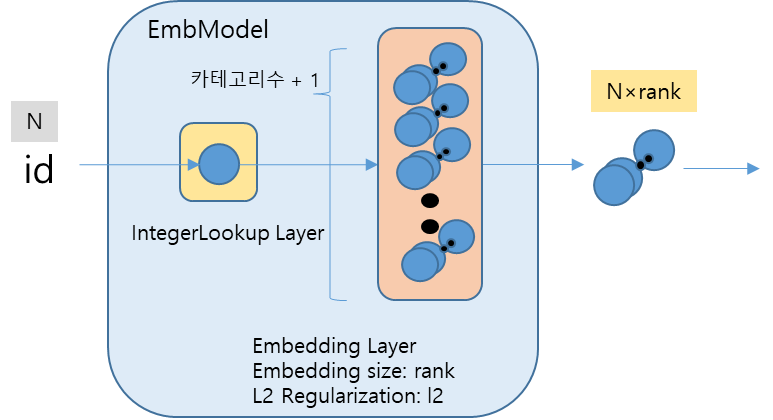

In [16]:
class EmbModel(tf.keras.Model):
    def __init__(self, ids, rank, l2=0):
        """
        정수형 ID로 된 임베딩을 받아서 임베딩 벡터를 반환시켜 주는 모델
        Parameters: 
            ids: list
                카테고리의 수준들의 id 리스트
            rank: int
                임베딩 벡터의 사이즈
            l2: float
                l2 규제 계수
        """
        super().__init__()
        # 정수형 ID를 1-based Index로 반환해주는 Layer를 만듭니다. - 0은 OOV(out-of-vocabulary)입니다.
        self.lu_ids = tf.keras.layers.IntegerLookup(
            vocabulary=tf.constant(ids)
        )
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        # Index에 대한 Embedding을 반환하는 Layer를 생성합니다.
        self.emb = tf.keras.layers.Embedding(len(ids) + 1, rank, embeddings_regularizer=reg)
    
    def call(self, x, training=False):
        x = self.lu_ids(x) # 정수형 ID(Nx1) → Embedding Index (N×1)
        return self.emb(x, training=training) # Embedding Index 

### Mean Model

EmbModel을 사용하여 평균 모델을 구성합니다.

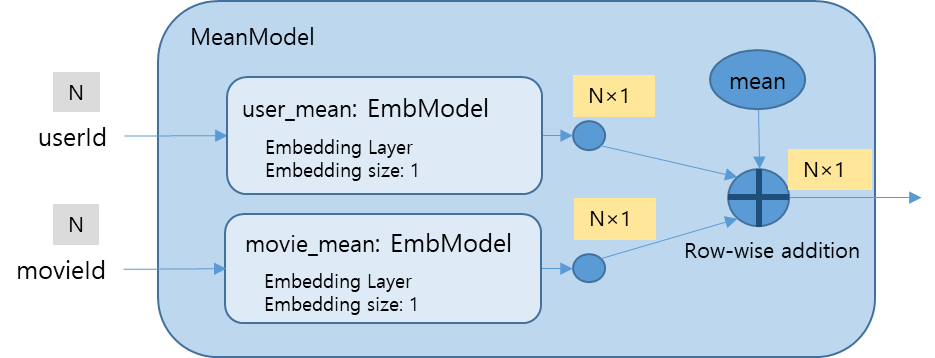

In [17]:
# 평균, 사용자 평균 모델, 영화 평균 모델을(사이즈가 1인 임베딩 모델) 받아 평균 모델을 구성합니다.
class MeanModel(tf.keras.Model):
    def __init__(self, mean, user_mean_model, movie_mean_model):
        """
        Parameters:
            mean: float
                평균
            user_mean_model: EmbModel
                사용자 평균 모델
            movie_mean_mode: EmbModel
                영화 평균 모델
        """
        super().__init__()
        # 사용자의 평균을 담고 있는 모델을
        self.mean = tf.constant([mean], dtype=tf.float32)
        self.user_mean_model = user_mean_model
        self.movie_mean_model = movie_mean_model
        
    def call(self, x, training=False):
        return self.mean + \
            self.user_mean_model(x['userId'], training=training) + \
            self.movie_mean_model(x['movieId'], training=training)

### Matrix Factorization Model

사용자의 rank 크기의 임베딩을 만드는 user_model

영화의 rank 크기의 임베딩을 만드는 movie_model

각각의 임베딩을 서로 행단위로 내적을 하여 평점을 출력하는 모델을 만듭니다.

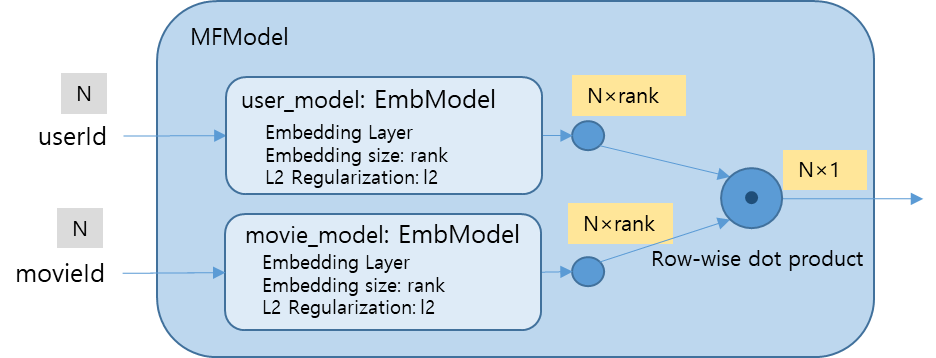

In [18]:
# 사용자 임베딩 모델과 영화 임베딩 모델을 받아, Matrix Factorization 모델을 구성합니다.
# user_model과 movie_model의 model 종류을 달리하며 받을 수 있도록, 
# 매개 변수화 한 것 입니다.
class MFModel(tf.keras.Model):
    def __init__(self, user_model, movie_model):
        """
        Parameters:
            user_model - tf.keras.Model
                사용자 모델
            movie_model - tf.keras.Model
                영화 모델
        """
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.dot = tf.keras.layers.Dot(axes=-1) # axes = -1 로 설정하면 Row-wise(행단위)로 내적 연산을 수행합니다.
    
    def call(self, x, training=False):
        x_user = self.user_model(x['userId'], training=training)
        x_movieId = self.movie_model(x['movieId'], training=training)
        return self.dot([x_user, x_movieId])

### 가법 모델

가장 간단한 앙상블 모델로 여러 모델의 Output을 더하여 하나의 Output으로 만듭니다.

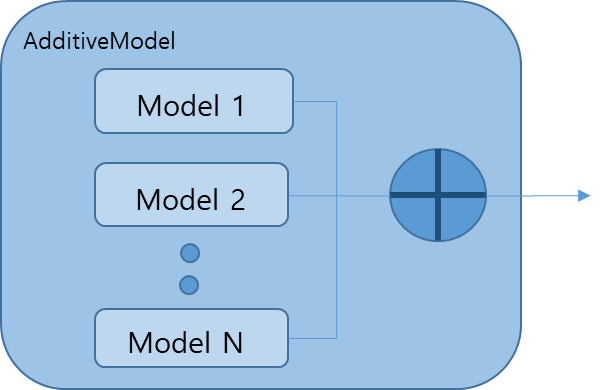

In [19]:
# 제공한 모델 각각의 예측 결과를 더하는 모델을 만듭니다.
class AdditiveModel(tf.keras.Model):
    def __init__(self, models):
        """
        Parameters:
            models: list
                tf.keras.Model 객체로 이루진 리스트입니다.
        """
        super().__init__()
        self.models = models
        
    def call(self, x, training=False):
        # 각각의 모델에서 나온 출력을 모으기 위한 리스트 입니다.
        y_hat = []
        for i in self.models:
            y_hat.append(i(x, training=training))
        # tf.reduce_sum: 주어진 텐서의 합을 구해줍니다. axis = 0: 첫번째 차원(모델의 위치를 나타내는 차원)에 대한 합을 구합니다.
        return tf.reduce_sum(y_hat, axis=0)

# 학습 및 성능 평가

**학습**

컴파일된 모델을 1 Epoch 단위로 Fit을 시켜, 

각 Epoch 별로 성능 평가를 하여, 학습이 진행됨에 따라 성능의 차이를 모니터링합니다.

**성능 평가**

Cold Start Problem 문제와 모델 주기적 재학습 문제가 어떤 양상으로 나타나는지 살펴봅니다.

그래서 train에서의 사용자/아이템의 등장횟수에 따라 각각을 그룹핑합니다.

각 그룹의 test의 성능이 어떻게 달라지는 지 확인해 봅니다.

In [20]:
from sklearn.metrics import mean_squared_error

def predict(a_model, ds, batch_size = 1024, verbose=True):
    return np.squeeze(a_model.predict(ds.batch(batch_size), verbose= 1 if verbose else 0))

def train_rcmd_model(a_model, epoches, user_bins, movie_bins, batch_size=1024, prd_batch_size=4096, shuffle_buffer_size=100000, verbose=True):
    """
    모델을 입력 받아 학습을 시킵니다.
    학습데이터에 user id와 item id의 빈도수에 따라 평가데이터에서의 성능을 집계하여 DataFrame으로
    결과를 반환합니다.
    Parameters:
        a_model: tf.keras.model
            추천 모델
        epoches: int int
            최적화 과정의 반복횟수
        user_bins: list
            성능 측정시 사용자 평가 빈도 구간
        movie_bins: list
            성능 측정시 영화 평가 빈도 구간
        batch_size: int
            데이터셋 배치 사이즈
        shuffle_buffer_size: int
            Train Set을 섞어주는 버퍼 사이즈
        verbose: int
            진행 상황 출력
    Returns: DataFrame
        사용자와 영화의 평가 빈도별 모델 검증 결과를 담은 DataFrame
    """
    # epoch 마다 결과를 기록해 놓을 list 입니다.
    mse_train = [] # 학습셋에 대한 mse
    mse_test = [] # 테스트셋에 대한 mse
    mse_by_userCnt = [] # 테스트셋에 대한 성능 사용자가 학습셋에 등장한 횟수에 따른 구간별 mse
    mse_by_movieCnt = [] # 테스트셋에 대한 성능 영화가 학습셋에 등장한 횟수에 따른 구간별 mse
    # 평가 데이터의 userId의 학습데이터의 출현 빈도를 구합니다.
    s_user_type = pd.cut(
        df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
    ).rename('userCnt')
    # 평가 데이터의 movieId의 학습데이터의 출현 빈도를 구합니다.
    s_movie_type = pd.cut(
        df_test['movieId'].map(df_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
    ).rename('movieCnt')
    for epoch in range(epoches):
        # ds_train을 shuffle_buffer_size만큼 섞어서 batch_size만큼
        a_model.fit(ds_train.shuffle(shuffle_buffer_size).batch(batch_size))
        # Train셋의 성능을 확인하기 위해 train셋에 대한 예측을 합니다.
        train_prds = predict(a_model, ds_train, prd_batch_size)
        # Test셋의 예측을 합니다.
        prds = predict(a_model, ds_test, prd_batch_size, False)

        # Train / Test의 성능으 측정하여 기록합니다.
        mse_train.append(mean_squared_error(df_train['rating'], train_prds))
        mse_test.append(mean_squared_error(df_test['rating'], prds))
        
        # Train에 등장한 사용자 빈도수 별로 구분하여 Test의 성능을 측정합니다.
        mse_by_userCnt.append(
            pd.DataFrame({
                'rating': df_test['rating'],
                'prds': prds
            }).groupby(s_user_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )

        # Test에 등장한 영화릐 빈도수 별로 구분하여 Test의 성능을 측정합니다.
        mse_by_movieCnt.append(
            pd.DataFrame({
                'rating': df_test['rating'],
                'prds': prds
            }).groupby(s_movie_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )

        # 사용자의 평점 빈도수 구분한 성능 측정결과와 영화의 평점 빈도수를 구분한 성능 측정결과를 합칩니다.
        df_result = pd.concat([
            pd.DataFrame({('', 'train'): mse_train, ('', 'test'): mse_test}),
            pd.concat(mse_by_userCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['userCnt'], x.index.tolist()]))
            ).T,
            pd.concat(mse_by_movieCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['movieCnt'], x.index.tolist()]))
            ).T
        ], axis=1)
        df_result.index = np.arange(1, len(df_result) + 1)
        df_result.name = 'epoch'
        if verbose:
            clear_output()
            display(df_result)
    return df_result

## Baseline 모델

MeanModel + Matrix Factorization(rank = 32)

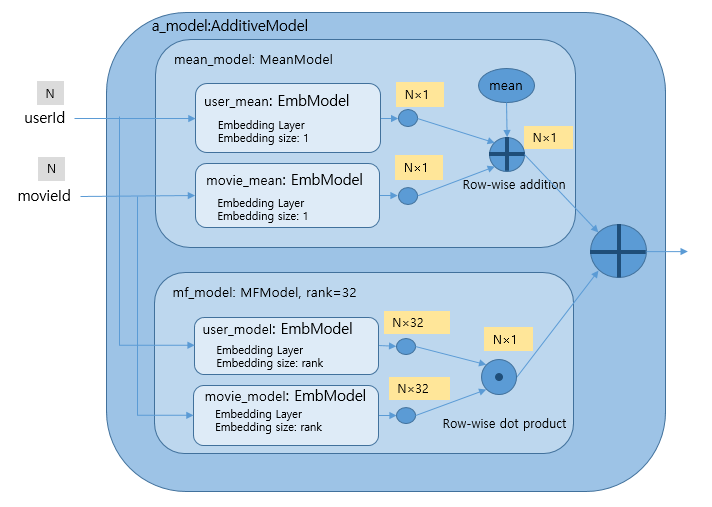

In [21]:
tf.keras.backend.clear_session()
rank = 32 # 사용자 / 영화 모델의 vector size를 32로 합니다.

# train셋에서 평가 이력이 120건 미만인 사용자에 대해서 임베딩을 사용은 역효과를 보게 되었습니다.
# 따라서, 120건 이상인 사용자를 대상으로 임베딩 벡터를 부여합니다.
user_model = EmbModel(
    s_userCnt.loc[s_userCnt >= 120].index.values,
    rank
)
# train셋에서 평가 이력이 100건 미만인 영화에 대해서 임베딩을 사용은 역효과를 보게 되었습니다.
# 따라서, 100건 이상인 영화를 대상으로 임베딩 벡터를 부여합니다.
movie_model = EmbModel(
    s_movieCnt.loc[s_movieCnt >= 100].index.values,
    rank
)
# user_model과 movie_model로 MFModel을 만듭니다.
mf_model = MFModel(user_model, movie_model)
# mf_model의 동작을 확인합니다.
mf_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.00293155],
       [ 0.00696877]], dtype=float32)>

In [22]:
user_mean_model = EmbModel(s_userCnt.loc[s_userCnt > 1].index.values, rank=1) # 사용자의 상대적 평균을 나타내는 모델입니다.
movie_mean_model = EmbModel(s_movieCnt.loc[s_movieCnt > 1].index.values, rank=1) # 영화의 상대적 평균을 나타내는 모델입니다.
mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model) # 사용자의 상대적 평균과 영화의 상대적 평균을 나타내는 모델을 MeanModel에 전달합니다.
# mean_model의 동작을 확인합니다.
mean_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.5781689],
       [3.6194696]], dtype=float32)>

In [23]:
# mf_model과 mean_model을 가법 모델로 앙상블합니다.
a_model = AdditiveModel([mf_model, mean_model])
# 가법 앙상블 모델의 동작을 확인합니다.
a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.5752373],
       [3.6264384]], dtype=float32)>

### 사용자의 평가 빈도에 따른 데이터의 분포를 확인합니다.

In [24]:
# 사용자의 평점 빈도수에 따른 평가 이력의 수와 비율을 살펴 봅니다.
user_bins = [0, 1, 120, 500, 1000, np.inf]
s_user_type = pd.cut(
    df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).rename('userCnt')
pd.concat([
    s_user_type.value_counts().rename('count'),
    s_user_type.value_counts(normalize=True).rename('ratio')
], axis=1)

,count,ratio
userCnt,,
"[0.0, 1.0)",930474,0.774986
"[120.0, 500.0)",91836,0.076490
"[1000.0, inf)",75826,0.063155
"[500.0, 1000.0)",53940,0.044926
"[1.0, 120.0)",48558,0.040444


### 영화의 평점 빈도에 따른 데이터의 분포를 확인합니다.

In [25]:
# 영화의 평점 빈도수에 따른 평가 이력의 수와 비율을 살펴 봅니다.
movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
s_movie_type = pd.cut(
    df_test['movieId'].map(df_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
).rename('movieCnt')
pd.concat([
    s_movie_type.value_counts().rename('count'),
    s_movie_type.value_counts(normalize=True).rename('ratio')
], axis=1)

,count,ratio
movieCnt,,
"[10000.0, inf)",442931,0.368914
"[1000.0, 5000.0)",279785,0.233031
"[5000.0, 10000.0)",190618,0.158764
"[100.0, 1000.0)",152343,0.126885
"[1.0, 100.0)",100575,0.083768
"[0.0, 1.0)",34382,0.028637


**nvdia-smi** : GPU의 상태를 체크해주는 프로그램

In [26]:
# mf.pkl 이 없으면 학습을 하고, 학습 산출물를 mf1.pkl에 저장합니다.
# mf.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
model_filename = os.path.join('model', 'mf.pkl')

# 기존에 학습된 모델을 다운로드 받습니다.
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=18TAOUpnZE3oM505r0gmrRxBXX5sb9Xam", quiet=False)
    os.rename(o, model_filename)

if not os.path.isfile(model_filename):
    tf.keras.backend.clear_session()
    rank = 32

    # 모델을 생성합니다.
    user_idx = s_userCnt.loc[s_userCnt > 120].index.values
    movie_idx = s_movieCnt.loc[s_movieCnt > 100].index.values
    user_model = EmbModel(user_idx, rank)
    movie_model = EmbModel(movie_idx, rank)
    mf_model = MFModel(user_model, movie_model)

    user_mean_idx = s_userCnt.loc[s_userCnt > 1].index.values
    movie_mean_idx = s_movieCnt.loc[s_movieCnt > 1].index.values
    user_mean_model = EmbModel(user_mean_idx, rank=1)
    movie_mean_model = EmbModel(movie_mean_idx, rank=1)
    mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
    # mf_model과 mean_model을 AdditiveModel로 결합합니다.
    a_model = AdditiveModel([mf_model, mean_model])
    # Adam Optimizer의 Learning Rate 즉, Gradient로 Weight를 업데이트 할 때의 가중치를 설정이 중요합니다.
    # 적정선 보다 크다면 탐색 공간을 지나치게 빠르게 지나가게 되므로, 최적의 학습정도를 파악하기 어렵고,
    # 적정선 보다 작다면 최적점까지 수렴하기에 많은 연산이 필요합니다.
    # 실험을 통해 얻은 가장 적절한 학습율은 3e-4였습니다.
    a_model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    user_bins = [0, 1, 120, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    df_result_mf = train_rcmd_model(a_model, 10, user_bins, movie_bins)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'rank': rank,
            'rating_train_mean': rating_train_mean,
            'user_idx': user_idx,
            'movie_idx': movie_idx,
            'user_mean_idx': user_mean_idx,
            'movie_mean_idx': movie_mean_idx,
            'result': df_result_mf,
            'weights': a_model.get_weights()
        }, f)
else:
    with open(model_filename, 'rb') as f:
        mf = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result_mf = mf['result']
    display(df_result_mf)
    # 모델을  만듭니다.
    tf.keras.backend.clear_session()
    rank = mf['rank']
    user_model = EmbModel(mf['user_idx'], rank)
    movie_idx = mf['movie_idx']
    movie_model = EmbModel(movie_idx, rank)
    mf_model = MFModel(user_model, movie_model)
    
    user_mean_model = EmbModel(mf['user_mean_idx'], rank=1)
    movie_mean_model = EmbModel(mf['movie_mean_idx'], rank=1)
    mean_model = MeanModel(mf['rating_train_mean'], user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model, mean_model])
    # 모델을 호출을 하면 구성된 모델의 Weights가 생성됩니다.
    a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})
    # 저장해두었던 가중치를 설정합니다.
    a_model.set_weights(mf['weights'])
    del mf

Downloading...
From: https://drive.google.com/uc?id=18TAOUpnZE3oM505r0gmrRxBXX5sb9Xam
To: /home/sun9sun9/jnote/rcmd_2503/mf.pkl
100%|██████████████████████████████████████| 10.7M/10.7M [00:01<00:00, 6.03MB/s]


userCnt                                              \
       train      test [0.0, 1.0) [1.0, 120.0) [120.0, 500.0) [500.0, 1000.0)   
1   0.722629  0.934387   0.977648     0.810155       0.897527        0.679523   
2   0.672486  0.924721   0.974681     0.784210       0.853577        0.648696   
3   0.633394  0.919083   0.974245     0.773022       0.827002        0.621615   
4   0.604911  0.916011   0.974052     0.769390       0.813928        0.602618   
5   0.583621  0.914863   0.974610     0.770262       0.807025        0.591136   
6   0.568219  0.914669   0.975378     0.772485       0.804208        0.584884   
7   0.557373  0.915175   0.976440     0.774850       0.803836        0.581392   
8   0.549655  0.916094   0.977685     0.777085       0.804588        0.579696   
9   0.544017  0.917374   0.979170     0.779512       0.806400        0.579070   
10  0.539738  0.919311   0.981343     0.782231       0.808712        0.578988   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1       0.709010   1.223637     1.126949        0.917322         0.953707   
2       0.684144   1.209510     1.102327        0.907714         0.945029   
3       0.658859   1.193474     1.085405        0.904381         0.938905   
4       0.644258   1.189105     1.079487        0.901552         0.934388   
5       0.635195   1.188845     1.076685        0.900132         0.932451   
6       0.629135   1.189482     1.076723        0.899899         0.931350   
7       0.625527   1.189726     1.077708        0.900860         0.931621   
8       0.623683   1.191459     1.079688        0.902376         0.932118   
9       0.622418   1.192272     1.083339        0.904799         0.933188   
10      0.621930   1.193777     1.085891        0.907516         0.935178   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1           0.926780       0.865148  
2           0.915708       0.859185  
3           0.910012       0.856459  
4           0.906848       0.855002  
5           0.905642       0.854777  
6           0.905103       0.855200  
7           0.905532       0.855642  
8           0.906171       0.856441  
9           0.907091       0.857112  
10          0.909154       0.858585

In [27]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict(a_model, ds_test, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
df_mf_user = df_prd.groupby(s_user_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
display(
    df_mf_user
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
df_mf_movie = df_prd.groupby(s_movie_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
display(
    df_mf_movie
)

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


userCnt
[0.0, 1.0)         0.981343
[1.0, 120.0)       0.782231
[120.0, 500.0)     0.808712
[500.0, 1000.0)    0.578988
[1000.0, inf)      0.621930
dtype: float32

movieCnt
[0.0, 1.0)           1.193777
[1.0, 100.0)         1.085891
[100.0, 1000.0)      0.907516
[1000.0, 5000.0)     0.935178
[5000.0, 10000.0)    0.909154
[10000.0, inf)       0.858585
dtype: float32

In [28]:
prd = a_model.predict(
    tf.data.Dataset.from_tensor_slices(
        {'userId': [149489] * len(df_movie), 'movieId': df_movie.index.tolist()}
    ).batch(128)
)
df_movie.iloc[np.argsort(-np.squeeze(prd))[:10]]

488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


,title,genres,release_date
movieId,,,
858,"Godfather, The (1972)",Crime|Drama,1972-03-14 00:00:00
159817,Planet Earth (2006),Documentary,2016-06-05 11:25:40
159819,Life (2009),Documentary,2016-06-05 11:27:34
171011,Planet Earth II (2016),Documentary,2017-04-18 08:53:17
231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,1994-12-16 00:00:00
912,Casablanca (1942),Drama|Romance,1942-11-26 00:00:00
1221,"Godfather: Part II, The (1974)",Crime|Drama,1974-12-20 00:00:00
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,1980-05-20 00:00:00
78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,2010-06-16 00:00:00


In [29]:
df_ratings.query('userId == 149489')[['movieId', 'rating']].assign(
    movieId = lambda x: x['movieId'].map(df_movie['title']),
    rating = lambda x: x['rating'].astype('int')
).rename(
    columns = {'movieId': 'title'}
).groupby('rating').apply(
    lambda x: x[['title']].head(5), include_groups = False
).sort_index(level=0, ascending = False)

title
rating                                                            
5      23008176                                      Psycho (1960)
       23008170  Star Wars: Episode V - The Empire Strikes Back...
       23008157                       2001: A Space Odyssey (1968)
       23008155                                 Rear Window (1954)
       23008154                                     Vertigo (1958)
4      23008273                                 Matrix, The (1999)
       23008208                   Hunt for Red October, The (1990)
       23008178                                   Chinatown (1974)
       23008137                   Silence of the Lambs, The (1991)
       23008088                         Usual Suspects, The (1995)
3      23008274                                  Entrapment (1999)
       23008272                                        EDtv (1999)
       23008270                                     Payback (1999)
       23008257                                   Rush Hour (1998)
       23008207                               Air Force One (1997)
2      23008258                                       Ronin (1998)
       23008223                                      Fallen (1998)
       23008210                              Kiss the Girls (1997)
       23008130                          Executive Decision (1996)
       23008096                       Devil in a Blue Dress (1995)
1      23008227                              Mercury Rising (1998)
       23008226                                 Wild Things (1998)
       23008217                                 Jackal, The (1997)
       23008135                                       Ghost (1990)
       23008090                                Broken Arrow (1996)

In [30]:
df_movie.join(
    pd.Series(
        movie_mean_model.emb.get_weights()[0][1:, 0], 
        index = s_movieCnt.loc[s_movieCnt > 1].index.values, name = 'rating'
    )
).dropna().join(
    df_ratings['movieId'].value_counts()
).sort_values('rating', ascending = False)

,title,genres,release_date,rating,count
movieId,,,,,
8129,Sex: The Annabel Chong Story (1999),Documentary,1999-02-11,1.037245,84
70970,Good (2008),Drama|War,2008-12-31,0.967816,42
2911,"Grandfather, The (Abuelo, El) (1998)",Drama,1998-10-16,0.946498,86
45658,On a Clear Day (2005),Drama,2005-08-18,0.945297,62
5181,Hangar 18 (1980),Action|Sci-Fi|Thriller,1980-07-01,0.938119,83
...,...,...,...,...,...
8722,Two of a Kind (1983),Comedy|Fantasy|Romance,1983-12-13,-1.599286,60
3915,Girlfight (2000),Drama,2000-05-01,-1.604527,749
89840,Killer Elite (2011),Action|Thriller,2011-09-22,-1.618601,661


In [31]:
log_dir='logs/m25m/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Embedding 항목의 메타 데이터를 기록합니다.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in movie_idx:
        f.write("{}\n".format(dic_movie_info_kr.get(i, {'original_title': 'unknown'})['original_title']))

# Embedding을 기록합니다.
weights =  tf.Variable(movie_model.get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 임베딩 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [32]:
# %tensorboard --logdir logs/m25m/ --bind_all

# Matrix Factorization + Neural Network

**Cold Start Problem** 을 해소하기 위한 가장 효과가 클 만한 요소는 사용자 쪽의 개선입니다. 

왜냐하면, Train에 전혀 등장하지 않은 사용자의 로그가 **77.4%** 이고, 오차 또한 큽니다

사용자의 메타 데이터는 없지만, 사용자가 이전에 평가했던 이력은 1번 이상 평가했던 사용자들에겐 유효합니다.

사용자가 이전에 시청한 영화 Embedding과 평점을 사용자 입력에 추가하는 방법을 사용합니다.

사용자 모델을 Embedding을 임베딩 층만을 이용한 것에서 확장하여, 

사용자의 Embedding, 이전 시청 영화의 임베딩, 그리고 이전 영화의 평점을 이용하여 사용자의 잠재 요소(Latent Factor)를 

나타내는 모델을 Neural Netowrk를 이용하여 모델을 만듭니다.

출력을 Matrix Factorization의 Rank로하는 Neural Network을 구성하는 모델로 User의 Embedding을 확장합니다.

### UserHistModel: + 사용자가 직전 평가한 영화와 평점

- prev movie id: 사용자가 직전 평가한 영화
- prev rating: 사용자가 직전 평가한 영화의 평점

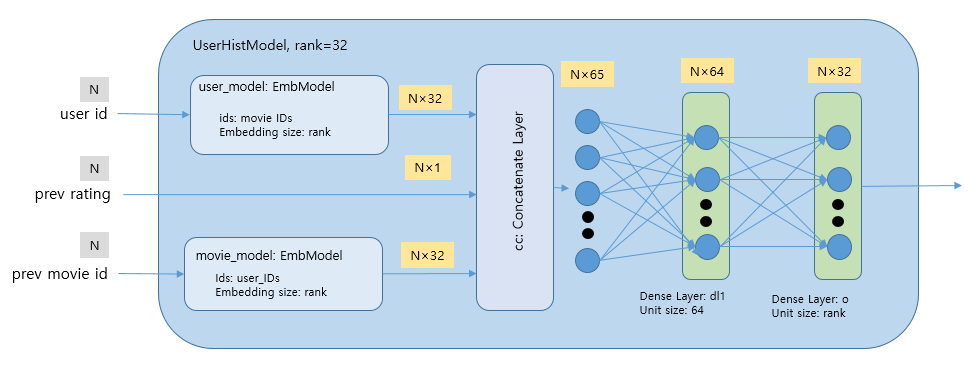

User Model과 Movie Model을 입력을 받아 사용자가 이전에 시청한 영화를 Movie Model을 통해 나타냅니다. 

이를 입력으로 출력이 rank인 단일 사용자 이력이 추가된 모델을 구성합니다.

In [33]:
class UserHistModel(tf.keras.Model):
    """
    사용자가 이전에 평가한 영화와 평점을 입력 받는 모델입니다.
    """
    def __init__(self, user_model, movie_model, rank, l2=0):
        """
        Parameters
            user_model: tf.keras.Model
                사용자 모델
            movie_model: tf.keras.Model
                영화 모델
            rank: int
                출력 벡터의 수
            l2: float
                L2 규제, 0일 때는 규제를 사용하지 않습니다.
        """
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        
        # Rank 벡터를 만들어 내기 위한 밀집 신경망을 구성합니다. 
        # 첫번째 은닉층(1st Hidden Layer )
        self.dl = tf.keras.layers.Dense(
            64, kernel_initializer = 'he_uniform', kernel_regularizer=reg,
            activation = 'relu'
        )
                                        
        
        # 출력층(Output Layer)
        self.o = tf.keras.layers.Dense(
            rank, kernel_initializer = 'glorot_uniform', kernel_regularizer = reg
        )
        
        # 사용자 벡터, 이전 시청 영화 벡터, 평점을 결합하기 위한 결합층(Concatenate Layer)을 생성합니다.
        self.cc = tf.keras.layers.Concatenate(axis = -1)

    def call(self, x, prev_movieId, prev_rating, training=False):
        vec = self.cc([
             self.user_model(x), # 사용자 벡터를 가져옵니다. N×rank
             self.movie_model(prev_movieId), # 이전 시청 영화 벡터를 가져옵니다. N×rank
             tf.expand_dims(prev_rating, axis=-1) # 이전 평점. N×1
        ]) # N×(2×rank + 1)
        
        vec = self.dl(vec) # 첫번째 은닉층. N×64
        return  self.o(vec) # 출력층. N×rank

### MFModel2

User 모델에 prev rating과 prev movie id를 전달하는 기능을 추가한 Matrix Factorization 모델을 만듭니다.

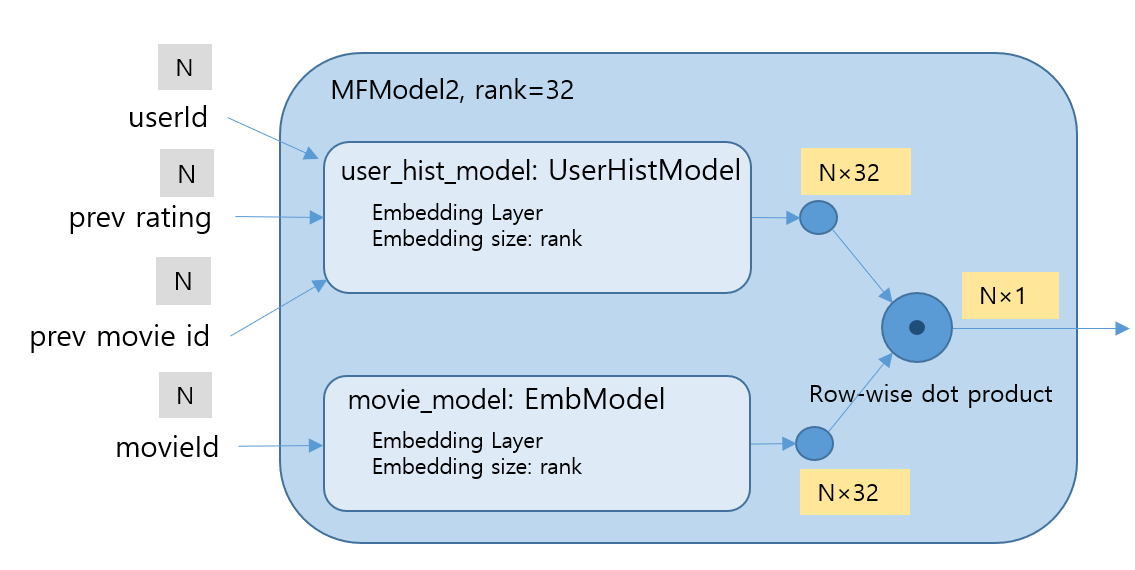

In [34]:
class MFModel2(tf.keras.Model):
    """
    MFModel에서 UserHistModel에 prev_movidId(이전 시청 영화 ID)와 prev_rating(이전 평점)을 전달 할 수 있도록 업그레이드한 모델입니다.
    """
    def __init__(self, user_hist_model, movie_model):
        super().__init__()
        self.user_hist_model = user_hist_model
        self.movie_model = movie_model
        # Row-wise dot Product를 하도록 설정합니다.
        self.dot = tf.keras.layers.Dot(axes=-1)
    
    def call(self, x, training=False):
        # 사용자 최종 모델 (UserHistModel)에 userId, prev_movieId, prev_rating을 입력하여
        # 사용자 벡터를 가져옵니다.
        x_user = self.user_hist_model(
            x['userId'], # N
            x['prev_movieId'], # N
            x['prev_rating'], # N
            training=training
        ) # N×32
        x_movieId = self.movie_model(
            x['movieId'], # N
            training=training
        ) # N×32
        return self.dot([x_user, x_movieId])

* mf_model2의 동작을 확인합니다.

In [35]:
tf.keras.backend.clear_session()
rank = 32
user_model = EmbModel( 
    s_userCnt.loc[s_userCnt >= 140].index.values, # 이전의 사용자의 시청 이력을 추가하면서 효용성을 보이는 사용자의 평점수가 140개로 높아졌습니다.
    rank, 
)
movie_model = EmbModel(
    s_movieCnt.loc[s_movieCnt >= 100].index.values, 
    rank, 
)
user_hist_model = UserHistModel(user_model, movie_model, rank)
mf_model2 = MFModel2(user_hist_model, movie_model)
mf_model2({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 
          'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.01480485],
       [0.09629083]], dtype=float32)>

In [36]:
user_mean_model = EmbModel(s_userCnt.loc[s_userCnt > 1].index.values, rank=1)
movie_mean_model = EmbModel(s_movieCnt.loc[s_movieCnt > 1].index.values, rank=1)
mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
a_model = AdditiveModel([mf_model2, mean_model])

a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]),
        'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.4748452],
       [3.607387 ]], dtype=float32)>

In [37]:
user_bins = [0, 1, 140, 500, 1000, np.inf]
# 사용자의 평점 빈도수에 따른 평가 이력의 수와 비율을 살펴 봅니다.
s_user_type = pd.cut(
    df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).rename('userCnt')
pd.concat([
    s_user_type.value_counts().rename('count'),
    s_user_type.value_counts(normalize=True).rename('ratio')
], axis=1)

,count,ratio
userCnt,,
"[0.0, 1.0)",930474,0.774986
"[140.0, 500.0)",82878,0.069029
"[1000.0, inf)",75826,0.063155
"[1.0, 140.0)",57516,0.047905
"[500.0, 1000.0)",53940,0.044926


In [38]:
# mf2.pkl 이 없으면 학습을 하고, 학습 산출물를 mf2.pkl에 저장합니다.
# mf2.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
model_filename = os.path.join('model', 'mf2.pkl')

# 이미 학습된 모델과 결과를 저장한 파일을 다운로드 받습니다.
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=1dfAi8ao2r6598EgJPR79EI9Dho5KtER4", quiet=False)
    os.rename(o, model_filename)

if not os.path.isfile(model_filename):
    rank = 32
    user_idx = s_userCnt.loc[s_userCnt > 140].index.values
    movie_idx = s_movieCnt.loc[s_movieCnt > 100].index.values
    user_model = EmbModel(user_idx, rank)
    movie_model = EmbModel(movie_idx, rank)
    user_hist_model = UserHistModel(user_model, movie_model, rank)
    mf_model2 = MFModel2(user_hist_model, movie_model)

    user_mean_idx = s_userCnt.loc[s_userCnt > 1].index.values
    movie_mean_idx = s_movieCnt.loc[s_movieCnt > 1].index.values
    user_mean_model = EmbModel(user_mean_idx, rank=1)
    movie_mean_model = EmbModel(movie_mean_idx, rank=1)
    mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model2, mean_model])
    a_model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    user_bins = [0, 1, 140, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    df_result_mf2 = train_rcmd_model(a_model, 10, user_bins, movie_bins)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'rank': rank,
            'rating_train_mean': rating_train_mean,
            'user_idx': user_idx,
            'movie_idx': movie_idx,
            'user_mean_idx': user_mean_idx,
            'movie_mean_idx': movie_mean_idx,
            'result': df_result_mf2,
            'weights': a_model.get_weights()
        }, f)
else:
    with open(model_filename, 'rb') as f:
        mf2 = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result_mf2 = mf2['result']
    display(df_result_mf2)
    # 모델을  만듭니다.
    tf.keras.backend.clear_session()
    rank = mf2['rank']
    user_model = EmbModel(mf2['user_idx'], rank)
    movie_idx = mf2['movie_idx']
    movie_model = EmbModel(mf2['movie_idx'], rank)
    user_hist_model = UserHistModel(user_model, movie_model, rank)
    mf_model2 = MFModel2(user_hist_model, movie_model)
    
    user_mean_model = EmbModel(mf2['user_mean_idx'], rank=1)
    movie_mean_model = EmbModel(mf2['movie_mean_idx'], rank=1)
    mean_model = MeanModel(mf2['rating_train_mean'], user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model2, mean_model])
    
    # 모델을 호출을 하면 구성된 모델의 Weights가 생성됩니다.
    a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]),
        'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})
    
    # 저장해두었던 가중치를 설정합니다.
    a_model.set_weights(mf2['weights'])
    del mf2

Downloading...
From: https://drive.google.com/uc?id=1dfAi8ao2r6598EgJPR79EI9Dho5KtER4
To: /home/sun9sun9/jnote/rcmd_2503/mf2.pkl
100%|██████████████████████████████████████| 9.81M/9.81M [00:01<00:00, 6.13MB/s]


userCnt                                              \
       train      test [0.0, 1.0) [1.0, 140.0) [140.0, 500.0) [500.0, 1000.0)   
1   0.737409  0.799218   0.819874     0.805203       0.768238        0.661355   
2   0.711497  0.790002   0.814079     0.796222       0.741079        0.638691   
3   0.699831  0.779963   0.803783     0.781030       0.732894        0.631303   
4   0.691161  0.778356   0.803010     0.775912       0.726809        0.626912   
5   0.682681  0.776849   0.801818     0.771290       0.722201        0.624955   
6   0.674308  0.778122   0.803544     0.769701       0.720836        0.625429   
7   0.668490  0.777422   0.803609     0.765348       0.718045        0.622411   
8   0.663731  0.779247   0.806297     0.764316       0.715475        0.621221   
9   0.659199  0.780373   0.808642     0.763473       0.711727        0.617474   
10  0.654176  0.781582   0.810880     0.763761       0.709490        0.613871   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1       0.673122   0.997405     0.932803        0.807768         0.804924   
2       0.650942   0.952879     0.875175        0.783211         0.802215   
3       0.644062   0.934840     0.843796        0.768316         0.790867   
4       0.641755   0.928524     0.826809        0.763473         0.791032   
5       0.642451   0.938632     0.824849        0.758023         0.789705   
6       0.643793   0.947959     0.827426        0.756875         0.793175   
7       0.640405   0.940506     0.827929        0.757343         0.795024   
8       0.640759   0.943001     0.827029        0.760268         0.798782   
9       0.637203   0.940312     0.825655        0.762615         0.800435   
10      0.633672   0.939023     0.820766        0.764499         0.801737   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1           0.793330       0.749489  
2           0.794383       0.750754  
3           0.787254       0.747427  
4           0.789577       0.747980  
5           0.788526       0.746722  
6           0.790534       0.746201  
7           0.789166       0.744027  
8           0.790887       0.744865  
9           0.792274       0.745988  
10          0.794629       0.747992

### 최종 모델의 평가 데이터에 대한 예측 결과를 구하고, 사용자와 영화의 평점 빈도에 따른 성능을 보입니다.

In [39]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict(a_model, ds_test, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_user_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_movie_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


userCnt
[0.0, 1.0)         0.810866
[1.0, 140.0)       0.763744
[140.0, 500.0)     0.709493
[500.0, 1000.0)    0.613867
[1000.0, inf)      0.633670
dtype: float32

movieCnt
[0.0, 1.0)           0.939019
[1.0, 100.0)         0.820747
[100.0, 1000.0)      0.764488
[1000.0, 5000.0)     0.801715
[5000.0, 10000.0)    0.794611
[10000.0, inf)       0.747989
dtype: float32

### + 영화 컬렉션, 장르, Overview Open AI Embedding 추가

In [40]:
# 영화를 모델링하기 위한 정보를 만들어 냅니다.

# 우선 genre를 가변수화 합니다.
# 그리고, series 정보를 합칩니다.
df_movieinfo = pd.concat([
    pd.concat([
        s_genre.apply(lambda x: i in x).astype('float32').rename('genre{}'.format(i))
        for i in s_genre.explode().unique()
    ], axis=1), s_series
], axis=1)

df_movieinfo['collection'] = df_movieinfo['collection'].fillna(0).astype(int)
# 영화마다 제목과 줄거리 Embedding을 ov_emb에 저장합니다.
df_movieinfo['ov_emb'] = df_movieinfo.index.to_series().map(movie_info_emb)
# avg_ov_emb: 등장하지 않은 영화의 줄거리 Embedding을 위해 Embedding이 있는 영화릐 평균을 구합니다.
avg_ov_emb = np.mean(
    np.vstack(
        df_movieinfo['ov_emb']
    ), axis=0
)
# df_movieinfo의 첫번째 행은 등장하지 않은 영화를 위한데이터 입니다. 평균 임베딩과 그외 다른 정보는 0으로 입력되게 합니다.
df_movieinfo = pd.concat([
    pd.DataFrame({'ov_emb': [avg_ov_emb], 'collection': [0]}, index=[0]),
    df_movieinfo
], axis=0).fillna(0)

# 테스트 데이터에만 등장한 Series 데이터는 제외 시킵니다.
df_movieinfo.loc[
    ~df_movieinfo['collection'].isin(df_train['movieId'].map(df_movieinfo['collection']).dropna().astype(int).unique()),
    'collection'
] = 0
df_movieinfo

,ov_emb,collection,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,...,genre10,genre11,genre12,genre13,genre14,genre15,genre16,genre17,genre18,genre19
0,"[1.0590974358515289e-05, -0.022024351007917938...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[-0.013183295726776123, -0.04171353206038475, ...",1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[0.012337977066636086, -0.02982921712100506, -...",2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[0.007722894661128521, -0.031341586261987686, ...",3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[-0.01674286276102066, -0.04053124412894249, 0...",0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179271,"[-0.00322210555896163, -0.012472666800022125, ...",2549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185837,"[-0.004075410310178995, -0.004565841052681208,...",2638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201983,"[-0.0025060151237994432, -0.006549420766532421...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205028,"[-0.00194028508849442, -0.015216832980513573, ...",1117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


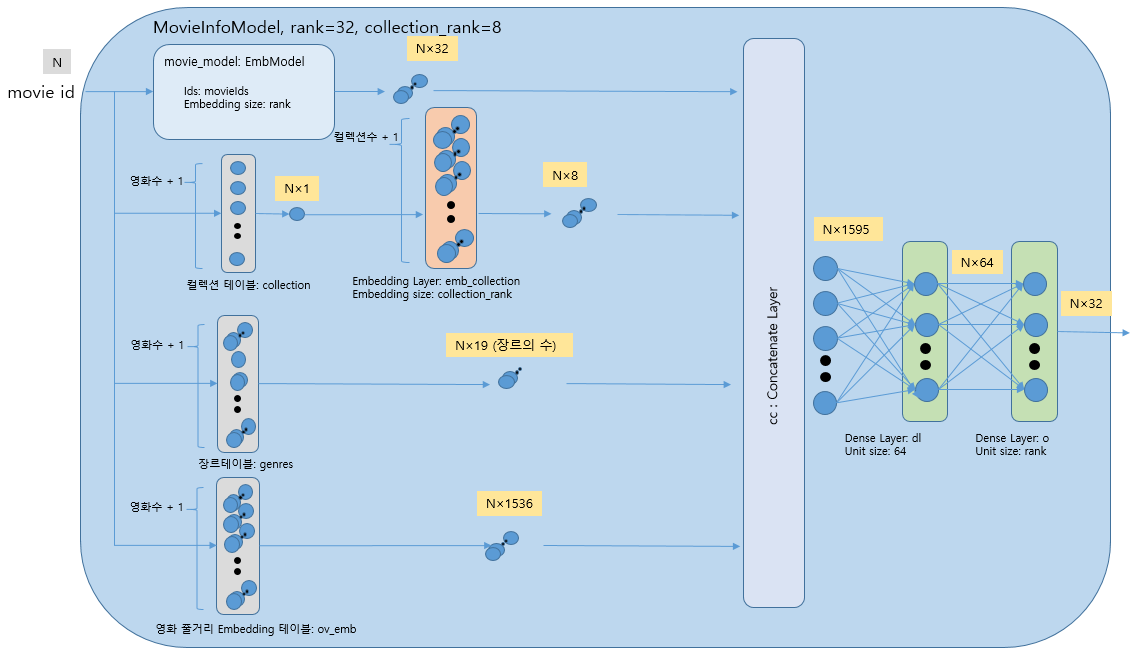

**메타데이터  탑재를 모델에 탑재시킵니다.**

* 영화의 메타데이터를 학습 데이터에 결합을 한다면, 학습 데이터가 커져서 메모리에 담기 어려워 집니다. 
  
  Ex) 사이즈가 1536인 OpenAI 영화 줄거리 임베딩을 학습 데이터에 결합한다면, 2500만 × 1536 × 8 bytes(Float 타입 사이즈) = 약 270GB
  
  이를 모델에 탑재하여 데이터 사이즈의 폭증하는 문제를 해소합니다. 
  
* 영화에 대한 메타데이터를 모델에 포함하여 모델에는 movie id만 전달하기만 하면 되므로, 메타 데이터를 건건히 전달할 필요가 없어 추상화를 통한 네트워크 구성의 간소화를 가져갈 수 있습니다.

→ 영화 장르는  19개의 가변수 형태입니다. 이것을 영화수 x 19의 상수 행렬로 만들어 탑재시킵니다.

→ 영화 줄거리 임베딩은 1536개의 vector입니다. 이것을 영화수 x 1536의 상수 행렬로 만들어 탑재시킵니다.

→ 시리즈 정보는 1개의 정수입니다. 영화수만큼의 벡터로 탑재시킵니다.

IntegerLookup 레이로 movieId에 따른 위치인덱스를 가져와서, 해당 위치의 장르, 줄거리, 시리즈 정보를 탑재된 행렬에서 가져옵니다.

tf.gather: 위치인덱스에 해당하는 텐서를 가져옵니다.

In [41]:
# 입력 데이터에 메타데이터를 넣으면 2500천만건 × 메타데이터수 만큼(genre 19개, 시리즈 1개, 영화줄거리 임베딩: 1536개) 만큼의 데이터가
# 생기므로, 커다란 용량이 필요합니다. 
# 모델의 아이템의 메타데이터를 탑재시킵니다.

# 우선 장르부터 해봅니다.
# 장르의 가변수명을 가져옵니다. 사용합니다.
cols_genre = [i for i in df_movieinfo.columns if i.startswith('genre')]
# 장르의 가변수를 상수 텐서로 만듭니다.
genres = tf.constant(
    df_movieinfo[[i for i in df_movieinfo.columns if i.startswith('genre')]]
)
genres

<tf.Tensor: shape=(60729, 19), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [42]:
# IntegerLookup을 통해 movieId에 대한 위치 인덱스를 가져옵니다.
lu_movie = tf.keras.layers.IntegerLookup(
    vocabulary=df_movieinfo.index[1:].values
)
# movieId가 1, 2 번인 영화의 위치 인덱스를 가져옵니다.
mid = lu_movie(tf.constant([1, 2, 206801]))
print(mid)
tf.gather(genres, mid)# tf.gather는 위치에 해당하는 내용을 가져옵니다.

tf.Tensor([    1     2 60728], shape=(3,), dtype=int64)


<tf.Tensor: shape=(3, 19), dtype=float32, numpy=
array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]], dtype=float32)>

In [43]:
df_movieinfo.loc[[1, 2, 60728], cols_genre]

,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genre11,genre12,genre13,genre14,genre15,genre16,genre17,genre18,genre19
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [44]:
# df_movieinfo['collection']
# 단일 데이터인 시리즈를 tf.constant로 만듭니다.
collection = tf.constant(df_movieinfo['collection'])
# 영화 줄거리 Embedding을 tf.constant로 만듭니다. df_movieinfo['ov_emb']
ov_emb = tf.constant(df_movieinfo['ov_emb'].tolist())

mid = lu_movie(tf.constant([2, 3, 206801]))
# 영화에 대한 데이터가 저장된 위치 인덱스를 가져옵니다.
tf.gather(ov_emb, mid)

<tf.Tensor: shape=(3, 1536), dtype=float64, numpy=
array([[ 0.01233798, -0.02982922, -0.0102611 , ..., -0.03060805,
        -0.00180267, -0.02200197],
       [ 0.00772289, -0.03134159,  0.00669053, ..., -0.01048249,
        -0.00704127, -0.01465166],
       [ 0.00722172,  0.00634434, -0.0208472 , ..., -0.0220916 ,
        -0.00236646, -0.0427011 ]])>

In [45]:
df_movieinfo.loc[[2, 3, 60728], 'ov_emb']

2        [0.012337977066636086, -0.02982921712100506, -...
3        [0.007722894661128521, -0.031341586261987686, ...
60728    [0.0007249639020301402, -0.02758054994046688, ...
Name: ov_emb, dtype: object

In [46]:
tf.gather(collection, mid)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 3, 0])>

In [47]:
df_movieinfo.loc[[2, 3, 60728], 'collection']

2        2
3        3
60728    0
Name: collection, dtype: int64

In [48]:
df_movieinfo.loc[[1, 2], 'ov_emb']

1    [-0.013183295726776123, -0.04171353206038475, ...
2    [0.012337977066636086, -0.02982921712100506, -...
Name: ov_emb, dtype: object

In [49]:
class MovieInfoModel(tf.keras.Model):
    def __init__(self, df_movieinfo, movie_model, emb_config, rank, l2=0):
        super().__init__()
        self.lu_movie = tf.keras.layers.IntegerLookup(
            vocabulary=df_movieinfo.index[1:].values
        )
        # 영화 별 장르 정보를 담고 저장공간생성
        cols_genre = df_movieinfo.columns[2:].tolist()
        self.genres = tf.constant(
            df_movieinfo[cols_genre]
        )
        # 영화의 컬렉션 정보를 지니고 있는 저장공간 생성
        self.collection = tf.constant(
            df_movieinfo['collection']
        )
        # 영화의 제목 + 줄거리의 OpenAI에서 구한 Embedding 정보 저장공간 생성
        self.ov_emb = tf.constant(
            df_movieinfo['ov_emb'].tolist()
        )
        
        self.movie_model = movie_model
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        self.emb_collection = tf.keras.layers.Embedding(
            df_movieinfo['collection'].max() + 1, 
            emb_config['collection'], 
            embeddings_regularizer = reg
        )

        # 은닉레이어 1: Dense(64)
        self.dl = tf.keras.layers.Dense(
            64, activation='relu', 
            kernel_initializer=tf.keras.initializers.HeNormal(), 
            kernel_regularizer=reg
        )
        # 출력 레이어: Dense(rank)
        self.o = tf.keras.layers.Dense(rank)
        # 결합 레이어
        self.cc = tf.keras.layers.Concatenate(axis = -1)
    
    def call(self, x, training=False):
        x_movie = self.movie_model(x, training=training)
        
        x = self.lu_movie(x)
        x_genre = tf.gather(self.genres, x) # 장르 여부를 가져옵니다.
        x_collection = tf.gather(self.collection, x) # 컬렉션 번호 가져옵니다.
        x_collection = self.emb_collection(x_collection) # 컬렉션 임베딩을 가져옵니다.
        x_ov_emb =  tf.gather(self.ov_emb, x) # OpenAI API를 얻은 영화 줄거리의 Embedding 정보를 가져 옵니다.
        x =  self.cc([
            x_movie, x_genre, x_collection, x_ov_emb
        ]) # x_movie, x_genre, x_collection, x_ov_emb를 결합하여 하나의 텐서로 만듭니다.
        x = self.dl(x)
        return self.o(x)

- mf2_model의 동작을 확인하고, mean_model과 앙상블 모델을 구성하여 최종 동작을 합니다.

In [50]:
tf.keras.backend.clear_session()
rank = 32
collection_rank = 8
user_model = EmbModel(s_userCnt.loc[s_userCnt >= 140].index.values, rank)
movie_model = EmbModel(s_movieCnt.loc[s_movieCnt >= 100].index.values, rank)
movie_info_model = MovieInfoModel(df_movieinfo, movie_model, {'collection': collection_rank}, rank)
user_hist_model = UserHistModel(user_model, movie_info_model, rank)
mf_model2 = MFModel2(user_hist_model, movie_info_model)
mf_model2({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 
          'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.02439254],
       [-0.05221631]], dtype=float32)>

In [51]:
user_mean_model = EmbModel(s_userCnt.loc[s_userCnt > 1].index.values, rank=1)
movie_mean_model = EmbModel(s_movieCnt.loc[s_movieCnt > 1].index.values, rank=1)
mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
mean_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.5710933],
       [3.4555476]], dtype=float32)>

In [52]:
a_model = AdditiveModel([mf_model2, mean_model])
a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]),
        'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.5467007],
       [3.4033313]], dtype=float32)>

In [53]:
# mf2_2.pkl 이 없으면 학습을 하고, 학습 산출물를 mf2_2.pkl에 저장합니다.
# mf2_2.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
model_filename = os.path.join('model', 'mf2_2.pkl')

# 이미 학습된 내용을 저장한 파일을 다운로드 받습니다.
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=1mnsZI6GreAJSw0IqcLP8mf50TgnmF711", quiet=False)
    os.rename(o, model_filename)

if not os.path.isfile(model_filename):
    rank = 32
    collection_rank = 8
    user_idx = s_userCnt.loc[s_userCnt > 140].index.values
    movie_idx = s_movieCnt.loc[s_movieCnt > 100].index.values
    user_model = EmbModel(user_idx, rank)
    movie_model = EmbModel(movie_idx, rank)
    movie_info_model = MovieInfoModel(df_movieinfo, movie_model, {'collection': collection_rank}, rank)
    user_hist_model = UserHistModel(user_model, movie_info_model, rank)
    mf_model2 = MFModel2(user_hist_model, movie_info_model)

    user_mean_idx = s_userCnt.loc[s_userCnt > 1].index.values
    movie_mean_idx = s_movieCnt.loc[s_movieCnt > 1].index.values
    user_mean_model = EmbModel(user_mean_idx, rank=1)
    movie_mean_model = EmbModel(movie_mean_idx, rank=1)
    mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model2, mean_model])
    a_model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-5),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    user_bins = [0, 1, 140, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    df_result = train_rcmd_model(a_model, 10, user_bins, movie_bins)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'rank': rank,
            'collection_rank': collection_rank,
            'rating_train_mean': rating_train_mean,
            'user_idx': user_idx,
            'movie_idx': movie_idx,
            'user_mean_idx': user_mean_idx,
            'movie_mean_idx': movie_mean_idx,
            'movieinfo': df_movieinfo,
            'result': df_result,
            'weights': a_model.get_weights()
        }, f)
else:
    with open(model_filename, 'rb') as f:
        mf2_2 = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result_mf2_2 = mf2_2['result']
    display(df_result_mf2_2)
    # 모델을  만듭니다.
    tf.keras.backend.clear_session()
    rank = mf2_2['rank']
    collection_rank = mf2_2['collection_rank']
    user_model = EmbModel(mf2_2['user_idx'], rank)
    movie_model = EmbModel(mf2_2['movie_idx'], rank)
    movie_info_model = MovieInfoModel(mf2_2['movieinfo'], movie_model, {'collection': collection_rank}, rank)
    user_hist_model = UserHistModel(user_model, movie_info_model, rank)
    mf_model2 = MFModel2(user_hist_model, movie_info_model)
    
    user_mean_model = EmbModel(mf2_2['user_mean_idx'], rank=1)
    movie_mean_model = EmbModel(mf2_2['movie_mean_idx'], rank=1)
    mean_model = MeanModel(mf2_2['rating_train_mean'], user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model2, mean_model])
    
    # 모델을 호출을 하면 구성된 모델의 Weights가 생성됩니다.
    a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 
          'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})
    
    # 저장해두었던 가중치를 설정합니다.
    a_model.set_weights(mf2_2['weights'])
    del mf2_2

Downloading...
From (original): https://drive.google.com/uc?id=1mnsZI6GreAJSw0IqcLP8mf50TgnmF711
From (redirected): https://drive.google.com/uc?id=1mnsZI6GreAJSw0IqcLP8mf50TgnmF711&confirm=t&uuid=c6d84117-86b6-49d6-93fe-25c63852f88b
To: /home/sun9sun9/jnote/rcmd_2503/mf2_2.pkl
100%|████████████████████████████████████████| 764M/764M [01:18<00:00, 9.69MB/s]


userCnt                                              \
       train      test [0.0, 1.0) [1.0, 140.0) [140.0, 500.0) [500.0, 1000.0)   
1   0.736930  0.783684   0.803581     0.796714       0.758224        0.658085   
2   0.722048  0.774974   0.796102     0.784441       0.748738        0.647414   
3   0.705373  0.770301   0.793136     0.775640       0.736209        0.634358   
4   0.695432  0.767812   0.791411     0.772354       0.728662        0.625612   
5   0.688155  0.765674   0.790621     0.768378       0.719412        0.615950   
6   0.681766  0.764623   0.790262     0.765799       0.715502        0.611840   
7   0.675179  0.764464   0.790637     0.764825       0.713098        0.609663   
8   0.667684  0.765244   0.792440     0.764387       0.708898        0.606734   
9   0.660794  0.767435   0.795418     0.765864       0.706833        0.607651   
10  0.655190  0.765037   0.793273     0.759627       0.702044        0.606087   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1       0.646805   0.948036     0.881738        0.769759         0.793478   
2       0.627940   0.929067     0.854442        0.759244         0.785551   
3       0.620006   0.937889     0.849347        0.755002         0.778386   
4       0.618735   0.939503     0.841666        0.754569         0.774666   
5       0.614559   0.947982     0.835646        0.749562         0.772768   
6       0.611471   0.941957     0.829545        0.748670         0.772547   
7       0.609288   0.937401     0.824328        0.749339         0.772943   
8       0.606509   0.946619     0.822451        0.747993         0.775384   
9       0.605144   0.935614     0.818144        0.750322         0.780795   
10      0.604568   0.947336     0.818522        0.746763         0.776394   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1           0.784694       0.746828  
2           0.779766       0.741634  
3           0.773803       0.737991  
4           0.770792       0.736658  
5           0.769860       0.734893  
6           0.769850       0.734347  
7           0.770382       0.734746  
8           0.772408       0.734620  
9           0.777465       0.735996  
10          0.773560       0.734183

In [54]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict(a_model, ds_test, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_user_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_movie_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


userCnt
[0.0, 1.0)         0.793298
[1.0, 140.0)       0.759649
[140.0, 500.0)     0.702082
[500.0, 1000.0)    0.606124
[1000.0, inf)      0.604586
dtype: float32

movieCnt
[0.0, 1.0)           0.947339
[1.0, 100.0)         0.818565
[100.0, 1000.0)      0.746799
[1000.0, 5000.0)     0.776407
[5000.0, 10000.0)    0.773579
[10000.0, inf)       0.734215
dtype: float32

In [55]:
log_dir='logs/m25m_2/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Embedding 메타 데이터를 기록합니다.
known = []
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in s_movieCnt.loc[s_movieCnt > 100].index:
        if i in df_movieinfo.index:
            f.write("{}\n".format(df_movie.loc[i, 'title']))
            known.append(i)
        
# Embedding을 기록합니다.
weights =  tf.Variable(movie_info_model(tf.constant(known)))
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 임베딩 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [56]:
# %tensorboard --logdir logs/m25m_2/ --bind_all